# 03_evaluate

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import json

HERE = Path.cwd().resolve()

def find_config(start: Path) -> Path:
    for p in [start, *start.parents]:
        cand = p / "project_config.json"
        if cand.exists():
            return cand
    raise FileNotFoundError("project_config.json not found. Run 00_config_and_checks.ipynb first.")

CONFIG_PATH = find_config(HERE)
cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))
print("Config:", CONFIG_PATH)

PROCESSED_DIR = Path(cfg["PROCESSED_DIR"])
MODELS_DIR = Path(cfg["MODELS_DIR"])
FIG_DIR = Path(cfg["FIG_DIR"])

test_df = pd.read_csv(PROCESSED_DIR / "test.csv")


# --- model discovery (supports both layouts) ---
TEXT_MODEL_DIR = MODELS_DIR / "text_model"

candidates = []

# Preferred layout: models/text_model/<version>/model.pkl
if TEXT_MODEL_DIR.exists():
    for p in TEXT_MODEL_DIR.iterdir():
        if p.is_dir() and (p / "model.pkl").exists():
            candidates.append(p / "model.pkl")

# Fallback layout (if you saved to models/v1/model.pkl by mistake)
for p in MODELS_DIR.iterdir():
    if p.is_dir() and (p / "model.pkl").exists():
        candidates.append(p / "model.pkl")

if not candidates:
    raise FileNotFoundError(
        f"No model.pkl found. Expected either:\n"
        f"  {TEXT_MODEL_DIR}/<version>/model.pkl\n"
        f"or fallback:\n"
        f"  {MODELS_DIR}/<version>/model.pkl"
    )

# pick latest by folder name (v1, v2, ...)
def _version_key(path: Path):
    return path.parent.name

model_path = sorted(candidates, key=_version_key)[-1]
model = joblib.load(model_path)

print("Loaded model:", model_path)


Config: C:\Users\viach\Downloads\document-classifier-portfolio-v2\project_config.json
Loaded model: C:\Users\viach\Downloads\document-classifier-portfolio-v2\models\text_model\v1\model.pkl


In [2]:
X_test = test_df["text"].astype(str).values
y_test = test_df["doc_type"].astype(str).values
pred = model.predict(X_test)

print(classification_report(y_test, pred, digits=3))

                  precision    recall  f1-score   support

           EMAIL      1.000     0.999     0.999      3000
         INVOICE      1.000     1.000     1.000      3000
SCIENTIFIC_PAPER      0.999     1.000     0.999      3000

        accuracy                          0.999      9000
       macro avg      0.999     0.999     0.999      9000
    weighted avg      0.999     0.999     0.999      9000



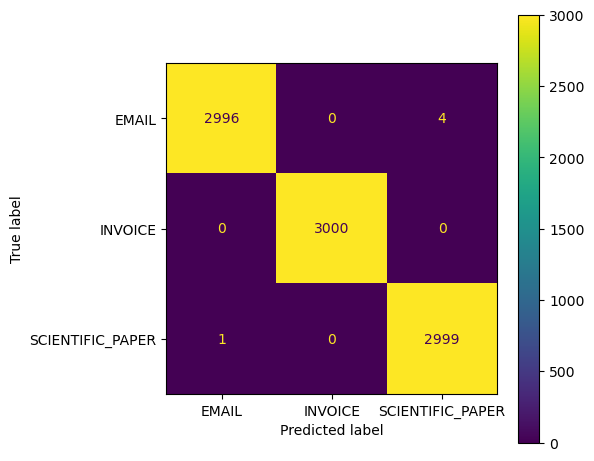

Saved: C:\Users\viach\Downloads\document-classifier-portfolio-v2\outputs\figures\text_model\cm_test_model.png


In [3]:
labels = list(getattr(model, "classes_", sorted(test_df["doc_type"].unique().tolist())))
cm = confusion_matrix(y_test, pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, values_format="d")
plt.tight_layout()

(FIG_DIR / "text_model").mkdir(parents=True, exist_ok=True)
out = (FIG_DIR / "text_model") / f"cm_test_{Path(model_path).stem}.png"
plt.savefig(out, dpi=160)
plt.show()

print("Saved:", out)

In [4]:
# Error table
proba_fn = getattr(model, "predict_proba", None)
rows = []
if proba_fn:
    proba = proba_fn(X_test)
    for i in range(len(X_test)):
        p = proba[i]
        order = np.argsort(-p)
        top1, top2 = int(order[0]), int(order[1])
        maxp = float(p[top1])
        margin = float(p[top1] - p[top2])
        if pred[i] != y_test[i]:
            rows.append({
                "doc_type": y_test[i],
                "pred": pred[i],
                "maxp": maxp,
                "margin": margin,
                "source": test_df.iloc[i].get("source", ""),
                "text": test_df.iloc[i]["text"][:240].replace("\n", " ")
            })

err = pd.DataFrame(rows).sort_values(["maxp","margin"], ascending=False)
err.head(20)

,doc_type,pred,maxp,margin,source,text
3,EMAIL,SCIENTIFIC_PAPER,0.620601,0.244151,ENRON,Would it be possible to use LiveLink to captur...
1,SCIENTIFIC_PAPER,EMAIL,0.616682,0.245043,ARXIV,A List of References on Spacetime Splitting an...
0,EMAIL,SCIENTIFIC_PAPER,0.612964,0.232106,ENRON,"Vince and Stinson, I did some reserach on the ..."
4,EMAIL,SCIENTIFIC_PAPER,0.566068,0.134256,ENRON,North America's integrated electricity market ...
2,EMAIL,SCIENTIFIC_PAPER,0.506386,0.014622,ENRON,Amy - I'd be very interested in participating ...
